## **Ćwiczenie 1. Platforma testowa** 

**Napisz skrypt w Pythonie/Matlabie umożliwiający wczytywanie i wizualizację badanych sygnałów.**

Program powinien umożliwiać obserwowanie wycinka sygnału dla zadanego przedziału czasowego, skalowanie osi wykresów i ich opis oraz zapis dowolnego wycinka sygnału do pliku o podanej nazwie.

Sygnały EKG mają format plików tekstowych, w których wiersze odpowiadają kolejnym próbkom, a kolumny kanałom pomiarowym (odprowadzeniom EKG).
W niektórych plikach pierwsza kolumna zawiera momenty czasu, a druga zawiera
wartości próbek sygnału EKG. W takim przypadku pierwsza kolumna służy do skalowania osi czasu.


Kolejne ćwiczenia będą polegały na stopniowym rozbudowywaniu platformy testowej o nowe funkcjonalności. Sprawozdanie powinno obejmować wszystkie ćwiczenia z przetwarzania sygnałów EKG. Do sprawozdania należy dołączyć kod. Przy okazji tworzenia sprawozdania warto rozważyć nauczenie się i wykorzystanie notatnika jupyter [2]. Można też przygotować raport w tradycyjny sposób.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from biosppy import storage
from biosppy.signals import ecg
from math import ceil
import librosa
import pandas as pd


def import_from_txt(path_to_file, fs):
    try:
        data = pd.read_csv(f"{path_to_file}", sep=" ", header=None)
    except:
        data = pd.read_csv(f"{path_to_file}", sep="  ", header=None)

    rows, number_of_columns = data.shape
    if number_of_columns == 2:  # if second column is time
        return [data[0], [data[1]]]
    data = data[:5000]
    N = rows  # number of samples
    T = (N - 1) / fs  # duration
    ts = np.linspace(0, T, N, endpoint=False)  # relative timestamps
    return [ts[:5000], data]


def make_chart(x, y, xlabel, ylabel):
    try:
        rows, number_of_charts = y.shape
    except:
        number_of_charts = 1
    rows = ceil(number_of_charts/2)
    fig, axs = plt.subplots(rows, 2)
    if rows == 1:
        axs = [axs]
    index_of_plot = 0
    for i in range(0, rows):
        if i == (rows - 1) and number_of_charts % 2 == 1:
            axs[i][0].plot(x, y[index_of_plot], lw=1)
            axs[i][0].set_title(f"kanał: {index_of_plot}")
            axs[i][0].set_xlabel("T[s]")
            index_of_plot += 1
            axs[i][0].grid()
        else:
            for j in range(0, 2):
                print(axs)
                axs[i][j].plot(x, y[index_of_plot], lw=1)
                axs[i][j].set_title(f"kanał: {index_of_plot}")
                axs[i][j].set_xlabel("T[s]")
                index_of_plot += 1
                axs[i][j].grid()
    plt.show()

/home/emilka/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


## **Ćwiczenie 2. Analiza sygnałów okresowych w dziedzinie częstotliwości** 

**Celem ćwiczenia jest praktyczne wypróbowanie funkcji numpy.fft i numpy.ifft do wyznaczania prostej i odwrotnej transformaty Fouriera.**

1. Wygeneruj ciąg próbek odpowiadający fali sinusoidalnej o częstotliwości 50 Hz i długości 65536.

2. Wyznacz dyskretną transformatę Fouriera tego sygnału i przedstaw jego widmo amplitudowe na wykresie w zakresie częstotliwości [0, fs/2], gdzie fs oznacza częstotliwość próbkowania.

3. Wygeneruj ciąg próbek mieszaniny dwóch fal sinusoidalnych (tzn. ich kombinacji liniowej) o częstotliwościach 50 i 60 Hz. Wykonaj zadanie z punktu 2 dla tego sygnału.

4. Powtórz eksperymenty dla różnych czasów trwania sygnałów, tzn. dla różnych częstotliwości próbkowania.

5. Wyznacz odwrotne transformaty Fouriera ciągów wyznaczonych w zadaniu 2 i porównaj z ciągami oryginalnymi.

**Zagadnienia:**
    - transformata Fouriera (ang. FT, Fourier Transform), 
    - szybka transformata Fouriera (ang. FFT, Fast Fourier Transforms), 
    - dyskretna transformata Fouriera (ang. DFT, Discrete Fourier Transform), 
    - widmo amplitudowe.

- Transformacja Fouriera rozkłada funkcję okresową na szereg funkcji okresowych tak, że uzyskana transformata podaje w jaki sposób poszczególne częstotliwości składają się na pierwotną funkcję.

- Transformata Fouriera dla umożliwienia analizy częstotliwościowej przekształca sygnał z domeny czasu w domenę częstotliwości.

    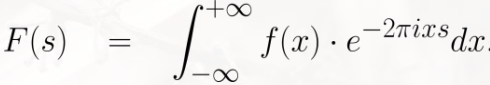

    x - czas (t) [s] 

    s - częstotliwość (f) [Hz = 1/2]

- Ponieważ w praktyce w wyniku pomiarów otrzymujemy dane o charakterze dyskretnym, a nie ciągłym, konieczne jest zdefiniowanie dyskretnego odpowiednika ciągłej transformaty Fouriera (zastępuje się całkę poprzez sumę):

    Dla N-elementowego ciągu dyskretną transformatę Fouriera definiujemy następująco:
    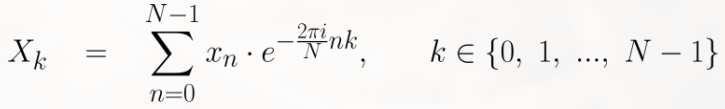

- FFT jest to DFT ze zmniejszoną liczbą niezbędnych operacji arytmetycznych. Celem FFT jest zmniejszenie długiego algorytmu obliczeniowego przez jego podział na krótsze i prostsze obliczenia DFT i skrócenie czasu obliczeń. Istnieją różne algorytmy FFT.

- Najpopularniejszą wersją FFT jest FFT o podstawie 2. Algorytm FFT o podstawie 2 jest bardzo efektywną procedurą wyznaczania DFT pod warunkiem, że rozmiar DFT będzie całkowitą potęgą liczby dwa. Dobrym podejściem jest dodanie wymaganej liczby próbek o wartościach zerowych do części koocowej ciągu danych czasowych, aby dopasowad liczbę jego punktów do kolejnego rozmiaru FFT o podstawie 2.

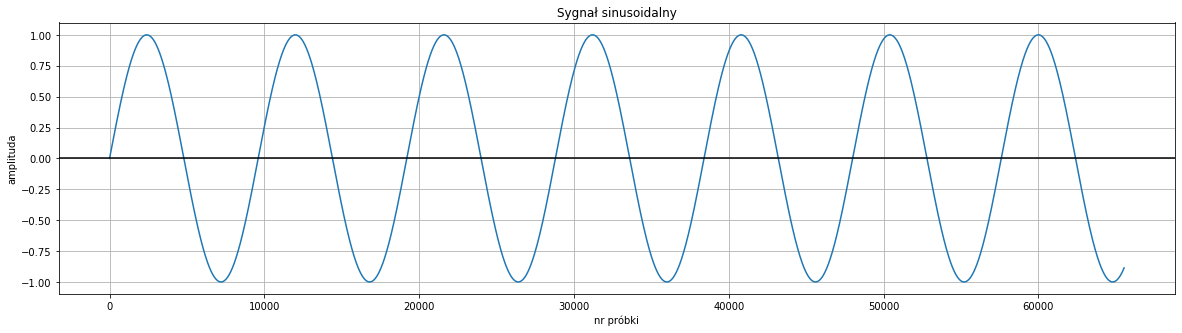

In [2]:
# 1. Wygeneruj ciąg próbek odpowiadający fali sinusoidalnej o częstotliwości 50 Hz
# i długości 65536.

import matplotlib.pyplot as plt
import numpy as np

# częstotliwość próbkowania
fs = 480000
# częstotliwość
f = 50
n = np.arange(65536)
sinus = np.sin(2 * np.pi * n * f / fs)
plt.figure(figsize=(20,5))
plt.plot(n, sinus)
plt.xlabel('nr próbki')
plt.ylabel('amplituda')
plt.title('Sygnał sinusoidalny')
plt.grid(True, which='both')
plt.axhline(y=0, color='k')
plt.show()

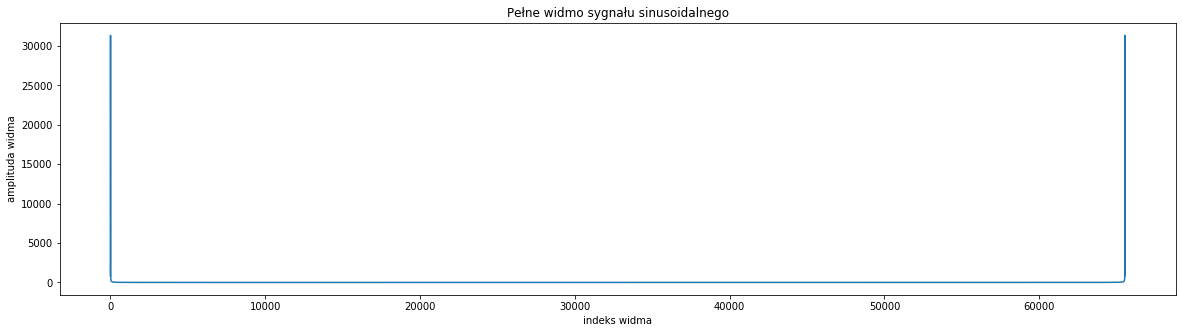

In [3]:
# 2. Wyznacz dyskretną transformatę Fouriera tego sygnału i przedstaw jego widmo
# amplitudowe na wykresie w zakresie częstotliwości [0, fs/2], gdzie fs oznacza
# częstotliwość próbkowania.

widmo = np.fft.fft(sinus)
widmo_amp = np.abs(widmo)
plt.figure(figsize=(20,5))
plt.plot(widmo_amp)
plt.xlabel('indeks widma')
plt.ylabel('amplituda widma')
plt.title('Pełne widmo sygnału sinusoidalnego')
plt.show()

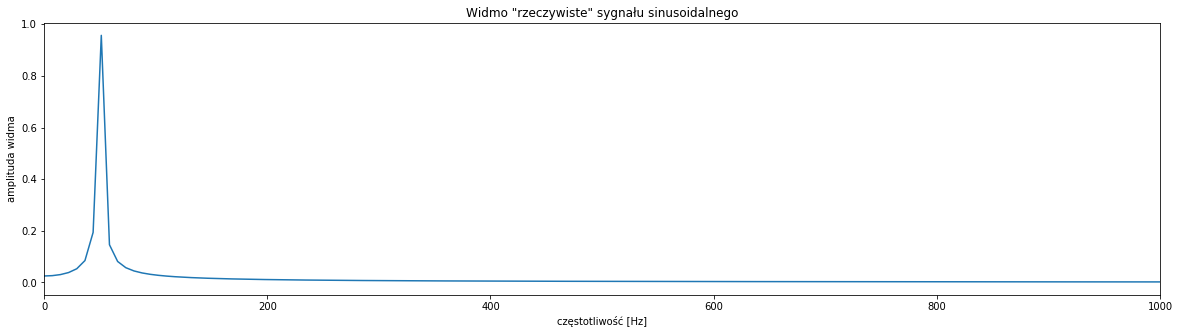

In [4]:
widmo_amp = np.abs(np.fft.rfft(sinus)) / (65536/2)
f = np.fft.rfftfreq(65536, 1/fs)
plt.figure(figsize=(20,5))
plt.plot(f, widmo_amp)
plt.xlim(0, 1000)
plt.xlabel('częstotliwość [Hz]')
plt.ylabel('amplituda widma')
plt.title('Widmo "rzeczywiste" sygnału sinusoidalnego')
plt.show()

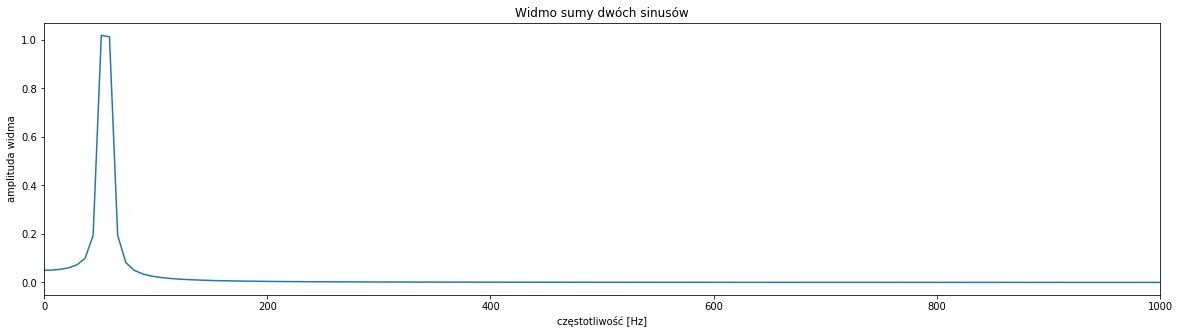

In [5]:
# 3. Wygeneruj ciąg próbek mieszaniny dwóch fal sinusoidalnych (tzn. ich kombinacji
# liniowej) o częstotliwościach 50 i 60 Hz. Wykonaj zadanie z punktu 2 dla tego
# sygnału.

fs = 480000
trzysin = (np.sin(2 * np.pi * n * 50 / fs) +
           np.sin(2 * np.pi * n * 60 / fs))
widmo_trzysin = np.fft.rfft(trzysin)
plt.figure(figsize=(20,5))
plt.plot(f, np.abs(widmo_trzysin) / (65536/2))
plt.xlim(0, 1000)
plt.xlabel('częstotliwość [Hz]')
plt.ylabel('amplituda widma')
plt.title('Widmo sumy dwóch sinusów')
plt.show()

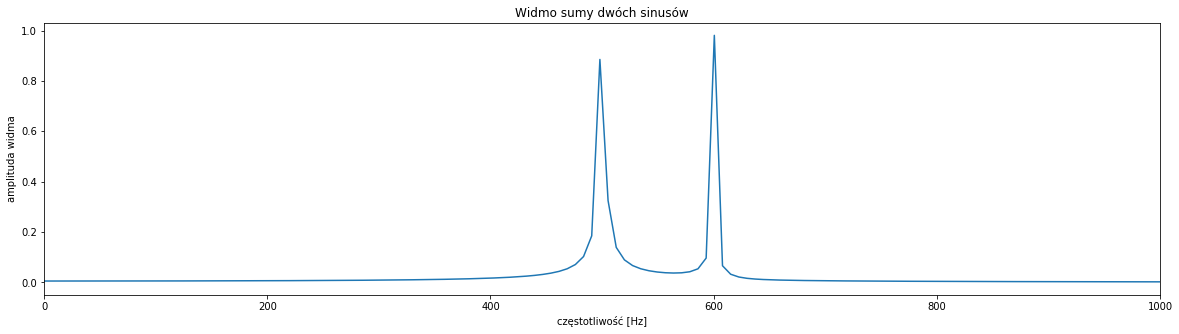

In [6]:
fs = 48000
trzysin = (np.sin(2 * np.pi * n * 50 / fs) +
           np.sin(2 * np.pi * n * 60 / fs))
widmo_trzysin = np.fft.rfft(trzysin)
plt.figure(figsize=(20,5))
plt.plot(f, np.abs(widmo_trzysin) / (65536/2))
plt.xlim(0, 1000)
plt.xlabel('częstotliwość [Hz]')
plt.ylabel('amplituda widma')
plt.title('Widmo sumy dwóch sinusów')
plt.show()

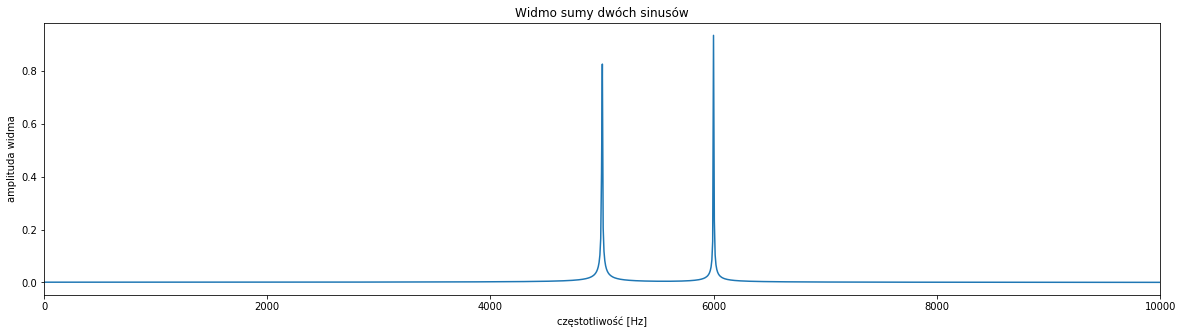

In [7]:
fs = 4800
trzysin = (np.sin(2 * np.pi * n * 50 / fs) +
           np.sin(2 * np.pi * n * 60 / fs))
widmo_trzysin = np.fft.rfft(trzysin)
plt.figure(figsize=(20,5))
plt.plot(f, np.abs(widmo_trzysin) / (65536/2))
plt.xlim(0, 10000)
plt.xlabel('częstotliwość [Hz]')
plt.ylabel('amplituda widma')
plt.title('Widmo sumy dwóch sinusów')
plt.show()

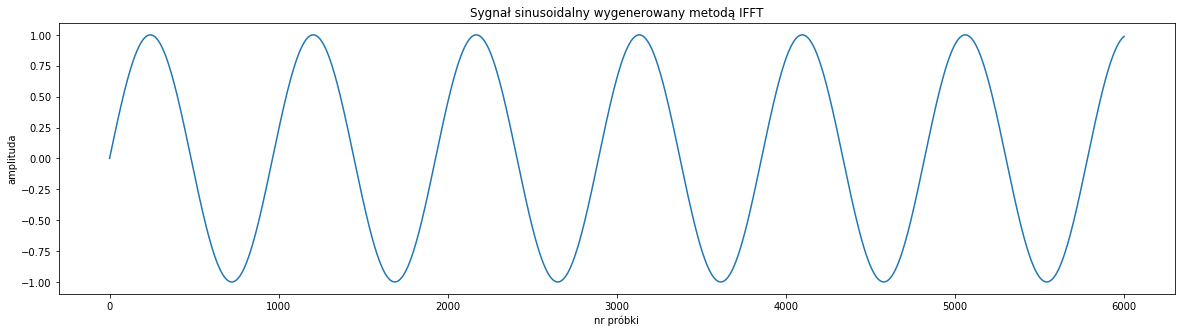

In [8]:
# 5. Wyznacz odwrotne transformaty Fouriera ciągów wyznaczonych w zadaniu 2
# i porównaj z ciągami oryginalnymi.

widmo = np.zeros(32769, dtype=np.complex)
widmo[68] = -32768j
wynik = np.real(np.fft.irfft(widmo))
plt.figure(figsize=(20,5))
plt.plot(wynik[:6000])
plt.xlabel('nr próbki')
plt.ylabel('amplituda')
plt.title('Sygnał sinusoidalny wygenerowany metodą IFFT')
plt.show()

## **Ćwiczenie 3. Analiza sygnału EKG w dziedzinie częstotliwości**

**Celem ćwiczenia jest obserwacja widma sygnału EKG. Analiza sygnału EKG w dziedzinie częstotliwości**

1. Wczytać sygnał ecg100.txt i ocenić go wizualnie na wykresie

2. Wyznaczyć jego dyskretną transformatę Fouriera i przedstawić widmo amplitudowe sygnału w funkcji częstotliwości w zakresie [0, fs/2], gdzie fs oznacza częstotliwość próbkowania.

3. Wyznaczyć odwrotną dyskretną transformatę Fouriera ciągu wyznaczonego w punkcie 2 i porównać otrzymany ciąg próbek z pierwotnym sygnałem ecg100 (można wyznaczyć różnicę sygnałów).

/home/emilka/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  


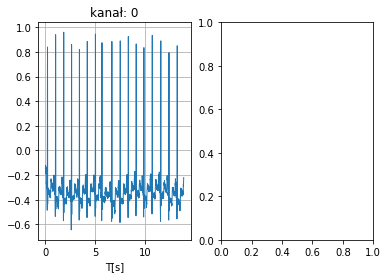

/home/emilka/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


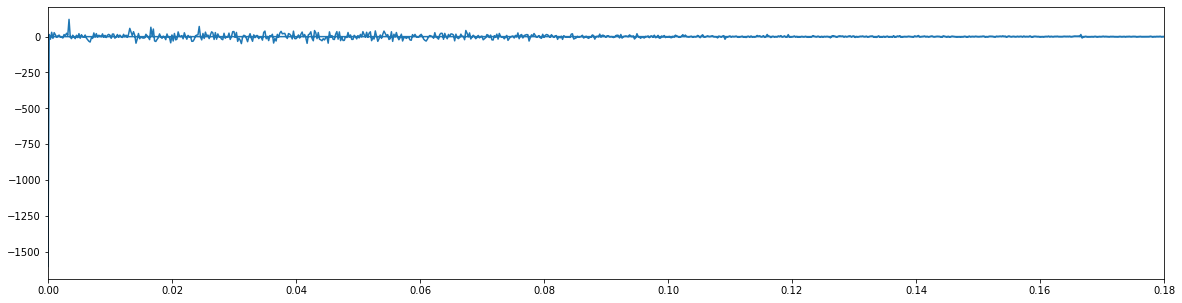

/home/emilka/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


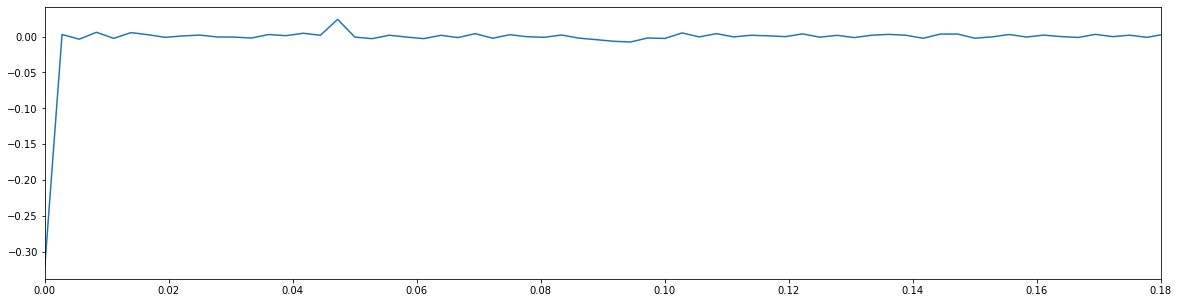

In [9]:
import scipy
from scipy import signal
from scipy import fftpack

import scipy.fftpack
from scipy.fftpack import fft
from scipy.fft import fftshift

import ecg as ecg
#import ftt as ftt

[ts, samples] = import_from_txt("./ekg_files/ekg100.txt", 360)
make_chart(ts, samples, "czas", "wartość")

# transformata fouriera
def fft(fs, ts, data):
    fs = fs/1000
    sp = np.fft.fft(flat(data.to_numpy()))
    freq = np.fft.fftfreq(len(ts))
    plt.figure(figsize=(20,5))
    plt.plot(freq, sp)  # .real, freq, sp.imag
    plt.xlim(0, fs / 2)
    plt.show()

    
# odwortna transformata fouriera
def ifft(fs, ts, data):
    fs = fs/1000
    sp = np.fft.ifft(flat(data.to_numpy()))
    # freq = np.fft.fftfreq(len(ts))
    freq = ts
    plt.figure(figsize=(20,5))
    plt.plot(freq, sp)
    plt.xlim(0, fs / 2)
    plt.show()


# służy do spłaszczania zagnieżdżonych list
def flat(listOfLists):
    newList = []
    for list in listOfLists:
        newList.append(list[0])
    return newList


fft(360, ts, samples)
ifft(360, ts, samples)

## **Ćwiczenie 4. Filtracja sygnału EKG**

**Celem ćwiczenia jest praktyczne wypróbowanie działania filtrów w celu wyeliminowania niepożądanych zakłóceń z sygnału EKG.**

Proszę wybrać rodzaj filtra do eksperymentowania, np. Butterwortha lub Czebyszewa. Do filtracji wykorzystać gotowe funkcje z biblioteki scipy.signal [7]. Biblioteka posiada również funkcje wspomagające projektowanie filtrów, które można zastosować.

1. Wczytaj sygnał ekg noise.txt i zauważ zakłócenia nałożone na sygnał. Wykreślić częstotliwościową charakterystykę amplitudową sygnału.

2. Zbadaj filtr dolnoprzepustowy o częstotliwości granicznej 60 Hz w celu redukcji zakłóceń pochodzących z sieci zasilającej. Wyznacz parametry filtra, wykreśl jego charakterystykę (zależność tłumienia od częstotliwości), przebieg sygnału po filtracji oraz jego widmo. Można też wyznaczyć różnicę między sygnałem przed i po filtracji i widmo tej różnicy.

3. Zastosuj następnie, do sygnału otrzymanego w punkcie 2, filtr górnoprzepustowy o częstotliwości granicznej 5 Hz w celu eliminacji pływania linii izoelektrycznej. Sporządź wykresy sygnałów jak w punkcie 2. 

Zauważ, że wykonując polecenia 2 i 3 dostaliśmy szeregowe połączenie filtrów odpowiednio dolno- i górnoprzepustowego, co jest równoważne zastosowaniu filtra pasmowoprzepustowego o paśmie przepustowym [5, 60] Hz.

- Filtry są układami elektronicznymi wykorzystywanymi w sytuacji gdy z sygnału trzeba wydzielić albo osłabić pewien zakres częstotliwości. W zależności od przeznaczenia rozróżniamy filtry:
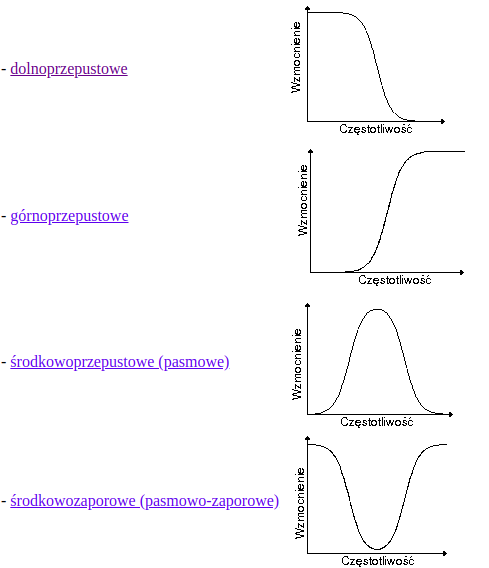

- Zadaniem filtra dolnoprzepustowego jest wydzielenie pewnego fragmentu częstotliwości z podanego sygnału, leżącego poniżej pewnej częstotliwości granicznej.

- Filtr Butterwortha to filtr charakteryzujący się maksymalnie płaską charakterystyką amplitudową w paśmie przenoszenia. Częstotliwość graniczną filtru wyznacza spadek sygnału o 3 dB.

In [10]:
# 1.
ekg_noise = pd.read_csv("./ekg_files/ekg_noise.txt", names=['czas','amplituda'], sep='\s+', index_col=0)
fs = 360 
ekg_noise.head()

,amplituda
czas,
0.000000,-0.325000
0.002778,-0.273038
0.005556,-0.268038
0.008333,-0.320000
0.011111,-0.391962


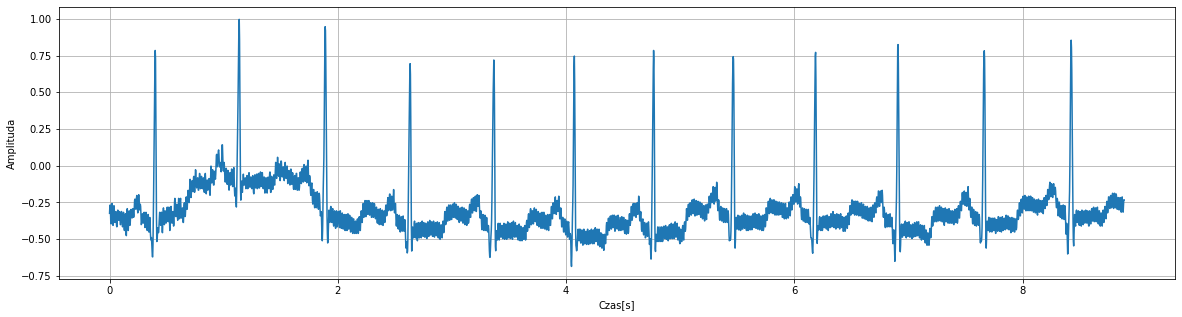

In [11]:
# Sygnał
plt.figure(figsize=(20,5))
plt.plot(ekg_noise)
plt.grid(axis='both')
plt.ylabel('Amplituda')
plt.xlabel('Czas[s]')
plt.show()

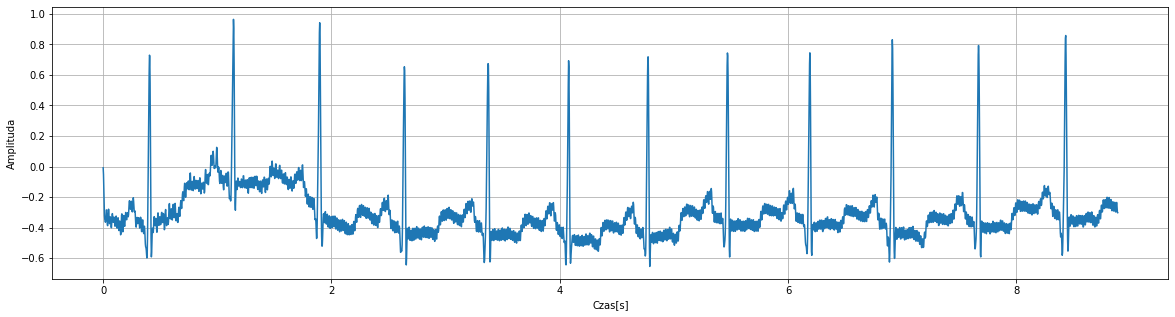

In [12]:
# 2. 
# Przebieg sygnału po filtracji dolnoprzepustowej
import scipy.signal

f_gran = 60
sos = signal.butter(4, f_gran, 'low', fs=360, output='sos')
fil_sig = signal.sosfilt(sos, ekg_noise['amplituda'])

plt.figure(figsize=(20,5))
plt.plot(ekg_noise.index, fil_sig)
plt.ylabel('Amplituda')
plt.xlabel('Czas[s]')
plt.grid(axis='both')

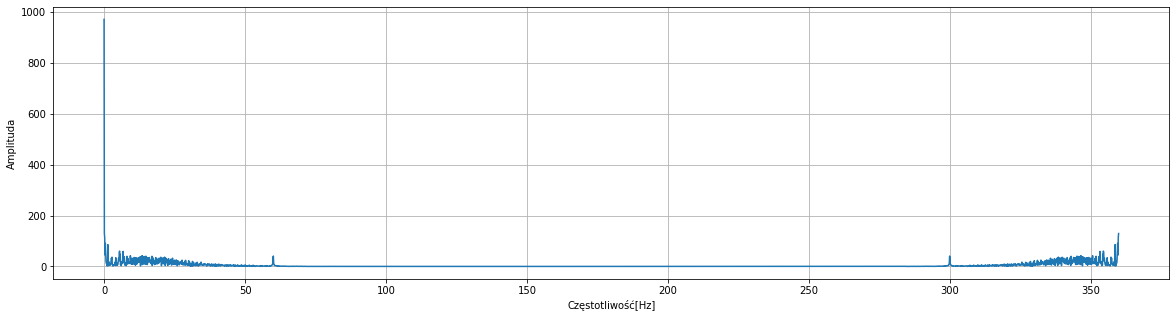

In [13]:
# Widmo sygnału
l = len(fil_sig)
fft = np.fft.fft(fil_sig)
fft = np.abs(fft)
x = 360 * np.arange(l)/l

plt.figure(figsize=(20,5))
plt.plot(x, fft)
plt.ylabel('Amplituda')
plt.xlabel('Częstotliwość[Hz]')
plt.grid(axis='both')

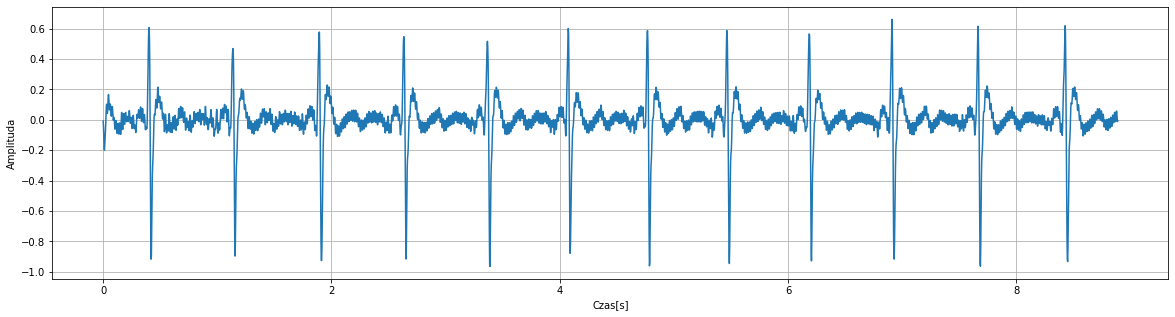

In [14]:
# 3.
# Przebieg sygnału po filtracji górnoprzepustowej
f_gran = 5
sos = signal.butter(4, f_gran, 'high', fs=360, output='sos')
fil_sig2 = signal.sosfilt(sos, fil_sig)

plt.figure(figsize=(20,5))
plt.plot(ekg_noise.index, fil_sig2)
plt.ylabel('Amplituda')
plt.xlabel('Czas[s]')
plt.grid(axis='both')

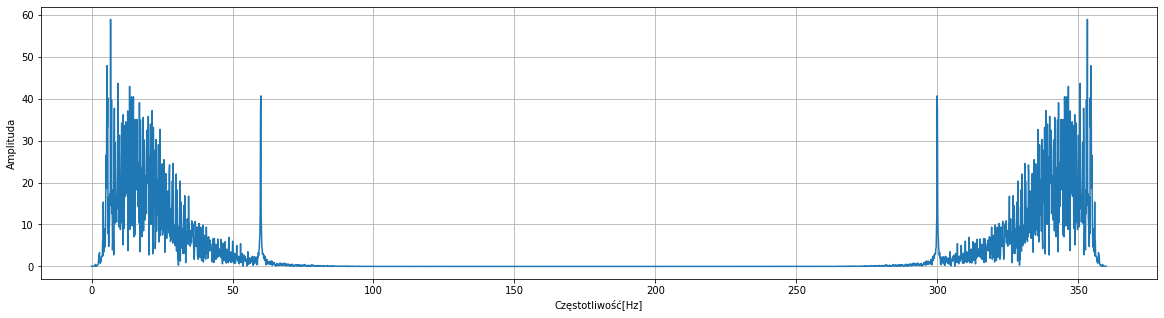

In [15]:
# Widmo sygnału
l = len(fil_sig2)
fft = np.fft.fft(fil_sig2)
fft = np.abs(fft)
x = 360 * np.arange(l)/l

plt.figure(figsize=(20,5))
plt.plot(x, fft)
plt.ylabel('Amplituda')
plt.xlabel('Częstotliwość[Hz]')
plt.grid(axis='both')